## Label Flipping

In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# dataset folder
data_dir = "./assignment2Data/trainingLabeled/"
label_dir = data_dir + "label/"

def flip_data(label_dir:str):

    # Save folder for flipped labels
    # Create a folder to save the images if it doesn't exist
    output_folder = './assignment2Data/trainingLabeledNoisy/label/'
    os.makedirs(output_folder, exist_ok = True)
    print('Predicted image labels will be saved in directory : ', output_folder)
    
    # ordered images and label
    labels = []

    # Get all files in the label_dir directory
    files = os.listdir(label_dir) # list
    img_files = [file for file in files if file.endswith('.png')]  # only PNG files
    
    for i, img_name in tqdm(enumerate(img_files)):
        label_pth = os.path.join(label_dir, img_name)
        
        # Load label
        lbl = Image.open(label_pth)

        # convert to ndarray
        label_img = np.array(lbl)

        # Count number of 255s (label has 2 values 0 and 255)
        num_255s = np.count_nonzero(label_img == 255)
        
        # Calculate number of pixels to flip (10% of the number of 255)
        num_to_flip = int(0.1 * num_255s)
        
        # Get the indices of the 255
        indices = np.argwhere(label_img == 255)
        
        # Randomly select indices to flip
        indices_to_flip = indices[np.random.choice(indices.shape[0], num_to_flip, replace=False)]
        
        # Flip labels at selected indices
        for idx in indices_to_flip:
            label_img[idx[0], idx[1]] = 0
        

        if i == 0:
            print("Number of 255s before & after flipping:", num_255s, np.count_nonzero(label_img == 255))


        # Save as image
            
        # Create a PIL image from the predicted labels
        img = Image.fromarray(label_img.astype(np.uint8))
    
        fname = os.path.join(output_folder, img_name)
        
        # Save the image as PNG
        img.save(fname)

    print('Successfully Saved the flipped version !!')

In [3]:
flip_data(label_dir)

Predicted image labels will be saved in directory :  ./assignment2Data/trainingLabeledNoisy/label/


30it [00:00, 297.67it/s]

Number of 255s before & after flipping: 6005 5405


120it [00:00, 280.80it/s]

Successfully Saved the flipped version !!


## Model training

__To solve segmentation-model error:__
    
1. Go to `"./../anaconda3/Lib/site-packages/efficientnet/__init__.py"`
2. In the file change `keras.utils.generic_utils.get_custom_objects().update(custom_objects)` to `keras.utils.get_custom_objects().update(custom_objects)`

In [1]:
# pip install tensorflow-addons

In [1]:
import sys
import tensorflow as tf
import tensorflow_addons as tfa
import keras
import osgeo
import segmentation_models as sm

2024-04-07 14:06:25.985901: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-07 14:06:26.007166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-07 14:06:26.007183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-07 14:06:26.007727: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-07 14:06:26.011446: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


/home/kshitij/anaconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
print(sys.version)
print(tf.__version__)
print(keras.__version__)
print(osgeo.__version__)
print(sm.__version__)

3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]
2.15.0
2.15.0
3.6.2
1.0.1


In [3]:
import os
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from keras.applications import VGG16, Xception, ResNet152V2, EfficientNetV2M, InceptionV3
from tensorflow.keras.layers import Input, Activation, Flatten, Dense, Reshape, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Conv2DTranspose, UpSampling2D, concatenate, Dropout, BatchNormalization
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint

### Load train data

In [4]:
# dataset folder
data_dir = "./assignment2Data/trainingLabeledNoisy/"
time1_dir = data_dir + "time1/"
time2_dir = data_dir + "time2/"
label_dir = data_dir + "label/"

def load_data(time1_dir:str, time2_dir:str, label_dir:str):
    # ordered images and label
    time1_images = [] 
    time2_images = []
    labels = []

    # Get all files in the time1 directory
    files = os.listdir(time1_dir) # list
    img_files = [file for file in files if file.endswith('.png')]  # only PNG files
    
    for img_name in tqdm(img_files):
        time1_img_pth = os.path.join(time1_dir, img_name)
        time2_img_pth = os.path.join(time2_dir, img_name)
        label_pth = os.path.join(label_dir, img_name)
        
        # Load image & label
        img_t1 = Image.open(time1_img_pth)
        img_t2 = Image.open(time2_img_pth)
        lbl = Image.open(label_pth)
        
        # convert to ndarray
        img_t1 = np.array(img_t1)
        img_t2 = np.array(img_t2)
        lbl = np.array(lbl)

        # scale each img to 0-1 range; normalizing each channels independently
        scaler = MinMaxScaler()
        num_channels = img_t1.shape[-1]
        img_t1 = scaler.fit_transform(img_t1.reshape(-1, num_channels)).reshape(img_t1.shape) # each column represent a band
        img_t2 = scaler.fit_transform(img_t2.reshape(-1, num_channels)).reshape(img_t2.shape) # each column represent a band
    
    
        time1_images.append(img_t1)
        time2_images.append(img_t2)
        labels.append(lbl)
        
    return time1_images, time2_images, labels

#### train set

100%|█████████████████████████████████████████| 120/120 [00:03<00:00, 33.38it/s]


120 120 120
2 [  0 255]


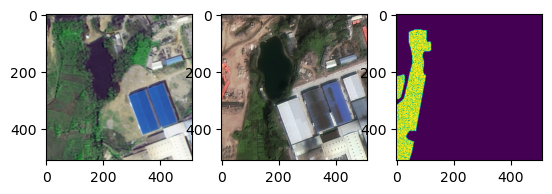

In [5]:
time1_images, time2_images, labels = load_data(time1_dir, time2_dir, label_dir)
print(len(time1_images), len(time2_images), len(labels))
# To find unique values of each all pixels in all images
unique_values = np.unique(np.array(labels).flatten())
print(len(unique_values), unique_values)

idx = random.randint(0, len(time1_images))
# Plot for image t1
plt.subplot(1, 3, 1)
plt.imshow(time1_images[idx])
# Plot for image t2
plt.subplot(1, 3, 2)
plt.imshow(time2_images[idx])
# Plot for label
plt.subplot(1, 3, 3)
plt.imshow(labels[idx])
plt.show()

In [6]:
# convert pixel values to label
for i in tqdm(range(len(labels))):
    labels[i][labels[i] == 0] = 0 # Replace 0 with 0
    labels[i][labels[i] == 255] = 1 # Replace 255 with 1

# To find unique values of each all pixels in all images
unique_values = np.unique(np.array(labels).flatten())
print(len(unique_values), unique_values)

100%|███████████████████████████████████████| 120/120 [00:00<00:00, 5130.07it/s]


2 [0 1]


In [7]:
# convert to array
time1_images, time2_images, label_array = np.array(time1_images), np.array(time2_images), np.array(labels)
print(time1_images.shape, time2_images.shape, label_array.shape)

(120, 512, 512, 3) (120, 512, 512, 3) (120, 512, 512)


#### test set

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 33.53it/s]


100 100 100
2 [  0 255]


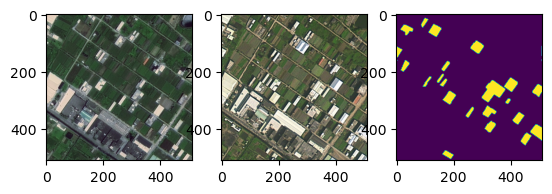

In [8]:
# dataset folder
data_dir = "./assignment2Data/testKnownLabel/"
time1_dir = data_dir + "time1/"
time2_dir = data_dir + "time2/"
label_dir = data_dir + "label/"

test1_images, test2_images, test_labels = load_data(time1_dir, time2_dir, label_dir)
print(len(test1_images), len(test2_images), len(test_labels))
# To find unique values of each all pixels in all images
unique_values_test = np.unique(np.array(test_labels).flatten())
print(len(unique_values_test), unique_values_test)

idx = random.randint(0, len(test1_images))
# Plot for image t1
plt.subplot(1, 3, 1)
plt.imshow(test1_images[idx])
# Plot for image t2
plt.subplot(1, 3, 2)
plt.imshow(test2_images[idx])
# Plot for label
plt.subplot(1, 3, 3)
plt.imshow(test_labels[idx])
plt.show()

In [9]:
# convert pixel values to label
for i in tqdm(range(len(test_labels))):
    test_labels[i][test_labels[i] == 0] = 0 # Replace 0 with 0
    test_labels[i][test_labels[i] == 255] = 1 # Replace 255 with 1

# To find unique values of each all pixels in all images
unique_values_test = np.unique(np.array(test_labels).flatten())
print(len(unique_values_test), unique_values_test)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 7043.10it/s]

2 [0 1]


In [10]:
# convert to array
test1_images, test2_images, test_labels = np.array(test1_images), np.array(test2_images), np.array(test_labels)
print(test1_images.shape, test2_images.shape, test_labels.shape)

(100, 512, 512, 3) (100, 512, 512, 3) (100, 512, 512)


### Model

In [11]:
def cd_model(base_model, IMG_HEIGHT=512, IMG_WIDTH=512, IMG_CHANNELS=3):
    # Freeze base_model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Get convolutional layers
    # to get only encoder block output 
    conv_layers_index = [] # encoder_layers_idx
    for index, layer in enumerate(base_model.layers):   # Iterate through the layers of the model
        if isinstance(layer, keras.layers.Concatenate):
            if 'decoder_stage' in layer.name:
                # Get the inbound nodes of the layer
                inbound_nodes = layer._inbound_nodes
                # Extract the list of input layers from the inbound nodes
                input_layers = [input_layer.name for input_layer in inbound_nodes[0].input_tensors]
                # Get the layer name at index 1 i.e from encoder
                second_layer_name = input_layers[1].split('/')[0] 
                # Get the index of the second layer in the model's layers list
                second_layer_index = [i for i, layer in enumerate(base_model.layers) if layer.name == second_layer_name][0]
                conv_layers_index.append(second_layer_index)
                
    print(len(conv_layers_index))

    def feature_extraction_model(base_model, i):
        x = base_model.layers[i].output
        return Model(inputs=base_model.input, outputs=x)

    # Define upsampling block
    def mlp_upsampling_block(x, filters, IMG_HEIGHT, IMG_WIDTH):
        x = Conv2D(16, (3, 3), strides=(2, 2), activation='relu', kernel_initializer='he_normal', padding='valid')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Conv2D(3, (3, 3), strides=(1, 1), activation='relu', kernel_initializer='he_normal', padding='valid')(x)
        x = BatchNormalization()(x)

        x = Flatten()(x)
        x = Dense(128, activation='relu')(x) # output activations no so that output shape should be H,W
        x = Dense(filters * IMG_HEIGHT//8 * IMG_WIDTH//8, activation='relu')(x)
        x = Reshape((IMG_HEIGHT//8, IMG_WIDTH//8, filters))(x)
        return x


    # Define a model to compute feature map differences at each convolutional layer
    def feature_map_difference_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
        input1 = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
        input2 = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))    
        
        feature_differences = []

        # Compute feature map differences at each convolutional layer; return shape: (H/8, W/8, channels)
        for i in conv_layers_index:
            feature_extractor = feature_extraction_model(base_model, i)
            features1 = feature_extractor(input1)
            features2 = feature_extractor(input2)
            difference = tf.math.abs(features2 - features1)

            # Upsample the difference to shape (H/8, W/8, channels)
            filters = 3 # difference.shape[-1]
            upsampled_difference = mlp_upsampling_block(difference, filters, IMG_HEIGHT, IMG_WIDTH)
            # print(upsampled_difference.shape)

            feature_differences.append(upsampled_difference)

        # Stack the differences
        x = tf.concat(feature_differences, axis=-1)

        x = UpSampling2D(size=(8, 8))(x) # to shape (H, W, channels) 

        x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding="same", kernel_initializer=RandomNormal(stddev=0.02))(x)
        x = tfa.layers.InstanceNormalization(axis=-1)(x)
        x = Activation("relu")(x)
        x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

        n_classes = 1 # as each pixel is eith 0 or 1 in label i.e has no channel dimen as shape is (512,512)
        outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(x)

        return Model(inputs=[input1, input2], outputs=outputs)

    # Create change detection model
    model = feature_map_difference_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
    
    return model

In [12]:
# Load pre-trained model

# encoder_freeze=False i.e training Encoder with imagenet as initial weights; as only encoder is needed for feature extraction
BACKBONE = 'resnet34'
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes= 1, activation='softmax',
               encoder_freeze=False, decoder_filters=(256, 128, 64, 32, 16), decoder_use_batchnorm=True)

model = cd_model(base_model, IMG_HEIGHT=time1_images.shape[1], IMG_WIDTH=time1_images.shape[2], IMG_CHANNELS=time1_images.shape[3])

2024-04-07 14:08:26.020805: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-07 14:08:26.039616: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-07 14:08:26.039745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

4


In [13]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 model_2 (Functional)        (None, None, None, 256)      8182985   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 model_3 (Functional)        (None, None, None, 128)      1354953   ['input_1[0][0]',       

In [14]:
# Compile the model
#Define loss, metrics and optimizer to be used for training
class_weights = [0.4,0.6]
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

metrics = ['accuracy', sm.metrics.FScore(class_weights=class_weights)]

lr = 0.001
optim = keras.optimizers.Adam(lr)

model.compile(optimizer=optim, loss= total_loss, metrics=metrics)

In [15]:
model_checkpoint_folder = './model_checkpoint/noisy_labelled/'
os.makedirs(model_checkpoint_folder, exist_ok = True)

filename = f'cd_resnet34.hdf5'
print('Model will be saved in directory : ', model_checkpoint_folder)
fname = os.path.join(model_checkpoint_folder, filename)

# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath = fname, monitor = 'f1-score', mode='max', save_best_only = True, verbose = 1)]    

# preprocess input
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train1 = preprocess_input(time1_images)
X_train2 = preprocess_input(time2_images)
print(X_train1.shape, X_train2.shape)

# Train the model
history_resnet34 = model.fit([X_train1, X_train2], label_array.astype('float32'), validation_split=0.1, shuffle=True, epochs=300, batch_size=8, callbacks = callbacks)

Model will be saved in directory :  ./model_checkpoint/noisy_labelled/
(120, 512, 512, 3) (120, 512, 512, 3)
Epoch 1/300


2024-04-07 14:10:17.403272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_6/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-07 14:10:17.968829: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-07 14:10:17.978359: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-04-07 14:10:18.048829: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-07 14:10:21.737444: I external/local_xla/xla/service/service.cc:168] XLA service 0x7188298072e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-07 14:10:21.737461: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 407

14/14 [==============================] - ETA: 0s - loss: 1.0502 - accuracy: 0.7888 - f1-score: 0.0505
Epoch 1: f1-score improved from -inf to 0.05054, saving model to ./model_checkpoint/noisy_labelled/cd_resnet34.hdf5


/home/kshitij/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 35s 1s/step - loss: 1.0502 - accuracy: 0.7888 - f1-score: 0.0505 - val_loss: 0.9765 - val_accuracy: 0.8742 - val_f1-score: 0.0881
Epoch 2/300
14/14 [==============================] - ETA: 0s - loss: 0.9851 - accuracy: 0.9334 - f1-score: 0.0487
Epoch 2: f1-score did not improve from 0.05054
14/14 [==============================] - 4s 313ms/step - loss: 0.9851 - accuracy: 0.9334 - f1-score: 0.0487 - val_loss: 0.9613 - val_accuracy: 0.8746 - val_f1-score: 0.0814
Epoch 3/300
14/14 [==============================] - ETA: 0s - loss: 0.9747 - accuracy: 0.9324 - f1-score: 0.0563
Epoch 3: f1-score improved from 0.05054 to 0.05628, saving model to ./model_checkpoint/noisy_labelled/cd_resnet34.hdf5
14/14 [==============================] - 5s 339ms/step - loss: 0.9747 - accuracy: 0.9324 - f1-score: 0.0563 - val_loss: 0.9651 - val_accuracy: 0.8746 - val_f1-score: 0.0810
Epoch 4/300
14/14 [==============================] - ETA: 0s - loss: 0.9586 - accuracy: 0

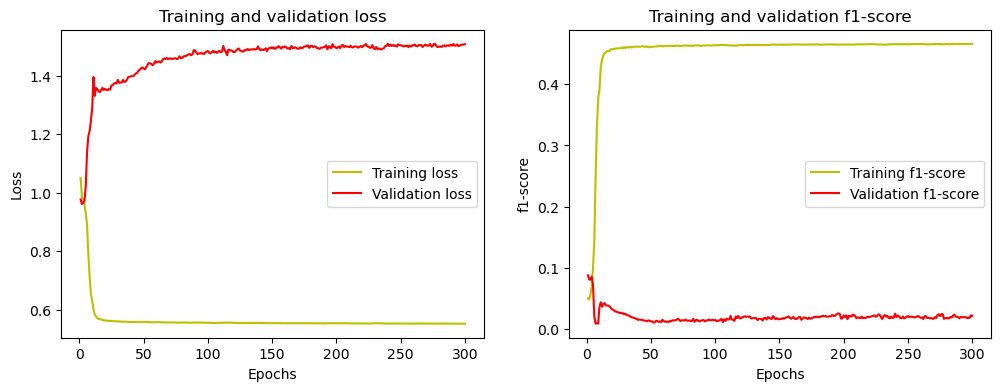

In [16]:
def acc_loss_plot(history):
    # Set the size of the figure
    plt.figure(figsize=(12, 4)) 

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation IoU
    plt.subplot(1, 2, 2)
    acc = history.history['f1-score']
    val_acc = history.history['val_f1-score']
    plt.plot(epochs, acc, 'y', label='Training f1-score')
    plt.plot(epochs, val_acc, 'r', label='Validation f1-score')
    plt.title('Training and validation f1-score')
    plt.xlabel('Epochs')
    plt.ylabel('f1-score')
    plt.legend()

    plt.show()

acc_loss_plot(history_resnet34)

In [17]:
# load the best model
model = tf.keras.models.load_model(fname, compile = False)

# preprocess input
preprocess_input = sm.get_preprocessing(BACKBONE)
X_test1 = preprocess_input(test1_images)
X_test2 = preprocess_input(test2_images)
print(X_test1.shape, X_test2.shape)

y_pred = model.predict([X_test1, X_test2], batch_size=8, verbose=2).squeeze(axis=-1)
# Convert predicted score to binary labels (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Flatten arrays
y_true = test_labels.flatten()
y_pred = y_pred.flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1]) # 1st row & column is class 0 & 2nd row & column is class 1

# Calculate metrics for class 1(positive) and class 0(negative)
tp = conf_matrix[1, 1]
fn = conf_matrix[1, 0]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]

# Compute sensitivity (true positive rate) for class 1
sensitivity = tp / (tp + fn)

# Compute specificity (true negative rate) for class 1
specificity = tn / (tn + fp)

# Compute overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)

# Compute F1 score
f1 = f1_score(y_true, y_pred)

print()
print("Sensitivity (TPR) for class 1:", round(sensitivity, 4))
print("Specificity (TNR) for class 1:", round(specificity, 4))
print("Overall Accuracy:", round(overall_accuracy, 4))
print("F1 Score:", round(f1, 4))

(100, 512, 512, 3) (100, 512, 512, 3)
13/13 - 2s - 2s/epoch - 191ms/step

Sensitivity (TPR) for class 1: 0.047
Specificity (TNR) for class 1: 0.961
Overall Accuracy: 0.8977
F1 Score: 0.0598


#### Seresnet34

In [18]:
BACKBONE = 'seresnet34'
base_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes= 1, activation='softmax',
               encoder_freeze=False, decoder_filters=(256, 128, 64, 32, 16), decoder_use_batchnorm=True)

model = cd_model(base_model, IMG_HEIGHT=time1_images.shape[1], IMG_WIDTH=time1_images.shape[2], IMG_CHANNELS=time1_images.shape[3])

4


In [19]:
# Compile the model
class_weights = [0.4,0.6]
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

metrics = ['accuracy', sm.metrics.FScore(class_weights=class_weights)]

lr = 0.001
optim = keras.optimizers.Adam(lr)

model.compile(optimizer=optim, loss= total_loss, metrics=metrics)

In [20]:
model_checkpoint_folder = './model_checkpoint/noisy_labelled/'
os.makedirs(model_checkpoint_folder, exist_ok = True)

filename = f'cd_seresnet34.hdf5'
print('Model will be saved in directory : ', model_checkpoint_folder)
fname = os.path.join(model_checkpoint_folder, filename)

# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath = fname, monitor = 'f1-score', mode='max', save_best_only = True, verbose = 1)]    

# preprocess input
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train1 = preprocess_input(time1_images)
X_train2 = preprocess_input(time2_images)
print(X_train1.shape, X_train2.shape)

# Train the model
history_seresnet34 = model.fit([X_train1, X_train2], label_array.astype('float32'), validation_split=0.1, shuffle=True, epochs=300, batch_size=8, callbacks = callbacks)

Model will be saved in directory :  ./model_checkpoint/noisy_labelled/
(120, 512, 512, 3) (120, 512, 512, 3)
Epoch 1/300


2024-04-07 14:32:59.608138: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_13/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


14/14 [==============================] - ETA: 0s - loss: 1.0932 - accuracy: 0.7227 - f1-score: 0.0508
Epoch 1: f1-score improved from -inf to 0.05079, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


/home/kshitij/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


14/14 [==============================] - 15s 498ms/step - loss: 1.0932 - accuracy: 0.7227 - f1-score: 0.0508 - val_loss: 0.9751 - val_accuracy: 0.8746 - val_f1-score: 0.0887
Epoch 2/300
14/14 [==============================] - ETA: 0s - loss: 0.9872 - accuracy: 0.9303 - f1-score: 0.0470
Epoch 2: f1-score did not improve from 0.05079
14/14 [==============================] - 5s 323ms/step - loss: 0.9872 - accuracy: 0.9303 - f1-score: 0.0470 - val_loss: 0.9658 - val_accuracy: 0.8741 - val_f1-score: 0.0846
Epoch 3/300
14/14 [==============================] - ETA: 0s - loss: 0.9706 - accuracy: 0.9313 - f1-score: 0.0611
Epoch 3: f1-score improved from 0.05079 to 0.06114, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 347ms/step - loss: 0.9706 - accuracy: 0.9313 - f1-score: 0.0611 - val_loss: 0.9710 - val_accuracy: 0.8741 - val_f1-score: 0.0837
Epoch 4/300
14/14 [==============================] - ETA: 0s - loss: 0.9493 - accuracy: 0.9234 - f1-score: 0.0799
Epoch 4: f1-score improved from 0.06114 to 0.07995, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 354ms/step - loss: 0.9493 - accuracy: 0.9234 - f1-score: 0.0799 - val_loss: 0.9884 - val_accuracy: 0.7791 - val_f1-score: 0.0846
Epoch 5/300
14/14 [==============================] - ETA: 0s - loss: 0.9214 - accuracy: 0.9154 - f1-score: 0.1116
Epoch 5: f1-score improved from 0.07995 to 0.11157, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 347ms/step - loss: 0.9214 - accuracy: 0.9154 - f1-score: 0.1116 - val_loss: 1.0335 - val_accuracy: 0.8184 - val_f1-score: 0.0595
Epoch 6/300
14/14 [==============================] - ETA: 0s - loss: 0.8616 - accuracy: 0.9338 - f1-score: 0.1744
Epoch 6: f1-score improved from 0.11157 to 0.17437, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 346ms/step - loss: 0.8616 - accuracy: 0.9338 - f1-score: 0.1744 - val_loss: 1.1778 - val_accuracy: 0.8723 - val_f1-score: 0.0130
Epoch 7/300
14/14 [==============================] - ETA: 0s - loss: 0.7725 - accuracy: 0.9546 - f1-score: 0.2622
Epoch 7: f1-score improved from 0.17437 to 0.26217, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 352ms/step - loss: 0.7725 - accuracy: 0.9546 - f1-score: 0.2622 - val_loss: 1.2678 - val_accuracy: 0.8735 - val_f1-score: 0.0038
Epoch 8/300
14/14 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.9698 - f1-score: 0.3462
Epoch 8: f1-score improved from 0.26217 to 0.34625, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 360ms/step - loss: 0.6888 - accuracy: 0.9698 - f1-score: 0.3462 - val_loss: 1.3159 - val_accuracy: 0.8741 - val_f1-score: 0.0021
Epoch 9/300
14/14 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.9773 - f1-score: 0.3887
Epoch 9: f1-score improved from 0.34625 to 0.38871, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 351ms/step - loss: 0.6397 - accuracy: 0.9773 - f1-score: 0.3887 - val_loss: 1.3273 - val_accuracy: 0.8681 - val_f1-score: 0.0085
Epoch 10/300
14/14 [==============================] - ETA: 0s - loss: 0.6052 - accuracy: 0.9839 - f1-score: 0.4202
Epoch 10: f1-score improved from 0.38871 to 0.42015, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.6052 - accuracy: 0.9839 - f1-score: 0.4202 - val_loss: 1.3573 - val_accuracy: 0.8685 - val_f1-score: 0.0077
Epoch 11/300
14/14 [==============================] - ETA: 0s - loss: 0.5890 - accuracy: 0.9865 - f1-score: 0.4347
Epoch 11: f1-score improved from 0.42015 to 0.43473, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 346ms/step - loss: 0.5890 - accuracy: 0.9865 - f1-score: 0.4347 - val_loss: 1.3554 - val_accuracy: 0.8679 - val_f1-score: 0.0080
Epoch 12/300
14/14 [==============================] - ETA: 0s - loss: 0.5785 - accuracy: 0.9885 - f1-score: 0.4423
Epoch 12: f1-score improved from 0.43473 to 0.44228, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.5785 - accuracy: 0.9885 - f1-score: 0.4423 - val_loss: 1.3443 - val_accuracy: 0.8665 - val_f1-score: 0.0099
Epoch 13/300
14/14 [==============================] - ETA: 0s - loss: 0.5722 - accuracy: 0.9892 - f1-score: 0.4492
Epoch 13: f1-score improved from 0.44228 to 0.44925, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 353ms/step - loss: 0.5722 - accuracy: 0.9892 - f1-score: 0.4492 - val_loss: 1.3413 - val_accuracy: 0.8618 - val_f1-score: 0.0136
Epoch 14/300
14/14 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.9898 - f1-score: 0.4509
Epoch 14: f1-score improved from 0.44925 to 0.45093, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 344ms/step - loss: 0.5695 - accuracy: 0.9898 - f1-score: 0.4509 - val_loss: 1.3362 - val_accuracy: 0.8597 - val_f1-score: 0.0152
Epoch 15/300
14/14 [==============================] - ETA: 0s - loss: 0.5671 - accuracy: 0.9902 - f1-score: 0.4536
Epoch 15: f1-score improved from 0.45093 to 0.45361, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 344ms/step - loss: 0.5671 - accuracy: 0.9902 - f1-score: 0.4536 - val_loss: 1.3418 - val_accuracy: 0.8581 - val_f1-score: 0.0163
Epoch 16/300
14/14 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.9902 - f1-score: 0.4515
Epoch 16: f1-score did not improve from 0.45361
14/14 [==============================] - 4s 316ms/step - loss: 0.5673 - accuracy: 0.9902 - f1-score: 0.4515 - val_loss: 1.3334 - val_accuracy: 0.8543 - val_f1-score: 0.0199
Epoch 17/300
14/14 [==============================] - ETA: 0s - loss: 0.5659 - accuracy: 0.9905 - f1-score: 0.4543
Epoch 17: f1-score improved from 0.45361 to 0.45433, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 350ms/step - loss: 0.5659 - accuracy: 0.9905 - f1-score: 0.4543 - val_loss: 1.3363 - val_accuracy: 0.8560 - val_f1-score: 0.0182
Epoch 18/300
14/14 [==============================] - ETA: 0s - loss: 0.5645 - accuracy: 0.9905 - f1-score: 0.4553
Epoch 18: f1-score improved from 0.45433 to 0.45525, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 345ms/step - loss: 0.5645 - accuracy: 0.9905 - f1-score: 0.4553 - val_loss: 1.3333 - val_accuracy: 0.8543 - val_f1-score: 0.0198
Epoch 19/300
14/14 [==============================] - ETA: 0s - loss: 0.5637 - accuracy: 0.9907 - f1-score: 0.4564
Epoch 19: f1-score improved from 0.45525 to 0.45640, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 347ms/step - loss: 0.5637 - accuracy: 0.9907 - f1-score: 0.4564 - val_loss: 1.3344 - val_accuracy: 0.8559 - val_f1-score: 0.0193
Epoch 20/300
14/14 [==============================] - ETA: 0s - loss: 0.5629 - accuracy: 0.9908 - f1-score: 0.4560
Epoch 20: f1-score did not improve from 0.45640
14/14 [==============================] - 4s 315ms/step - loss: 0.5629 - accuracy: 0.9908 - f1-score: 0.4560 - val_loss: 1.3334 - val_accuracy: 0.8528 - val_f1-score: 0.0215
Epoch 21/300
14/14 [==============================] - ETA: 0s - loss: 0.5627 - accuracy: 0.9909 - f1-score: 0.4569
Epoch 21: f1-score improved from 0.45640 to 0.45691, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 346ms/step - loss: 0.5627 - accuracy: 0.9909 - f1-score: 0.4569 - val_loss: 1.3360 - val_accuracy: 0.8530 - val_f1-score: 0.0217
Epoch 22/300
14/14 [==============================] - ETA: 0s - loss: 0.5639 - accuracy: 0.9908 - f1-score: 0.4549
Epoch 22: f1-score did not improve from 0.45691
14/14 [==============================] - 5s 328ms/step - loss: 0.5639 - accuracy: 0.9908 - f1-score: 0.4549 - val_loss: 1.3384 - val_accuracy: 0.8537 - val_f1-score: 0.0211
Epoch 23/300
14/14 [==============================] - ETA: 0s - loss: 0.5630 - accuracy: 0.9909 - f1-score: 0.4566
Epoch 23: f1-score did not improve from 0.45691
14/14 [==============================] - 4s 321ms/step - loss: 0.5630 - accuracy: 0.9909 - f1-score: 0.4566 - val_loss: 1.3408 - val_accuracy: 0.8555 - val_f1-score: 0.0198
Epoch 24/300
14/14 [==============================] - ETA: 0s - loss: 0.5622 - accuracy: 0.9909 - f1-score: 0.4563
Epoch 24: f1-score did not improve from 

14/14 [==============================] - 5s 351ms/step - loss: 0.5616 - accuracy: 0.9910 - f1-score: 0.4586 - val_loss: 1.3465 - val_accuracy: 0.8554 - val_f1-score: 0.0200
Epoch 26/300
14/14 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.9911 - f1-score: 0.4568
Epoch 26: f1-score did not improve from 0.45857
14/14 [==============================] - 4s 315ms/step - loss: 0.5619 - accuracy: 0.9911 - f1-score: 0.4568 - val_loss: 1.3484 - val_accuracy: 0.8523 - val_f1-score: 0.0229
Epoch 27/300
14/14 [==============================] - ETA: 0s - loss: 0.5611 - accuracy: 0.9912 - f1-score: 0.4581
Epoch 27: f1-score did not improve from 0.45857
14/14 [==============================] - 4s 314ms/step - loss: 0.5611 - accuracy: 0.9912 - f1-score: 0.4581 - val_loss: 1.3582 - val_accuracy: 0.8538 - val_f1-score: 0.0219
Epoch 28/300
14/14 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.9913 - f1-score: 0.4601
Epoch 28: f1-score improved from 0.45857

14/14 [==============================] - 5s 346ms/step - loss: 0.5597 - accuracy: 0.9913 - f1-score: 0.4601 - val_loss: 1.3490 - val_accuracy: 0.8526 - val_f1-score: 0.0238
Epoch 29/300
14/14 [==============================] - ETA: 0s - loss: 0.5595 - accuracy: 0.9914 - f1-score: 0.4590
Epoch 29: f1-score did not improve from 0.46007
14/14 [==============================] - 4s 315ms/step - loss: 0.5595 - accuracy: 0.9914 - f1-score: 0.4590 - val_loss: 1.3550 - val_accuracy: 0.8530 - val_f1-score: 0.0232
Epoch 30/300
14/14 [==============================] - ETA: 0s - loss: 0.5593 - accuracy: 0.9914 - f1-score: 0.4600
Epoch 30: f1-score did not improve from 0.46007
14/14 [==============================] - 4s 319ms/step - loss: 0.5593 - accuracy: 0.9914 - f1-score: 0.4600 - val_loss: 1.3664 - val_accuracy: 0.8549 - val_f1-score: 0.0216
Epoch 31/300
14/14 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.9915 - f1-score: 0.4601
Epoch 31: f1-score improved from 0.46007

14/14 [==============================] - 5s 349ms/step - loss: 0.5588 - accuracy: 0.9915 - f1-score: 0.4601 - val_loss: 1.3611 - val_accuracy: 0.8542 - val_f1-score: 0.0219
Epoch 32/300
14/14 [==============================] - ETA: 0s - loss: 0.5585 - accuracy: 0.9915 - f1-score: 0.4612
Epoch 32: f1-score improved from 0.46011 to 0.46117, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 346ms/step - loss: 0.5585 - accuracy: 0.9915 - f1-score: 0.4612 - val_loss: 1.3677 - val_accuracy: 0.8548 - val_f1-score: 0.0213
Epoch 33/300
14/14 [==============================] - ETA: 0s - loss: 0.5583 - accuracy: 0.9915 - f1-score: 0.4600
Epoch 33: f1-score did not improve from 0.46117
14/14 [==============================] - 4s 317ms/step - loss: 0.5583 - accuracy: 0.9915 - f1-score: 0.4600 - val_loss: 1.3710 - val_accuracy: 0.8550 - val_f1-score: 0.0214
Epoch 34/300
14/14 [==============================] - ETA: 0s - loss: 0.5584 - accuracy: 0.9916 - f1-score: 0.4609
Epoch 34: f1-score did not improve from 0.46117
14/14 [==============================] - 4s 319ms/step - loss: 0.5584 - accuracy: 0.9916 - f1-score: 0.4609 - val_loss: 1.3736 - val_accuracy: 0.8549 - val_f1-score: 0.0209
Epoch 35/300
14/14 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.9916 - f1-score: 0.4608
Epoch 35: f1-score did not improve from 

14/14 [==============================] - 5s 352ms/step - loss: 0.5577 - accuracy: 0.9917 - f1-score: 0.4617 - val_loss: 1.3748 - val_accuracy: 0.8554 - val_f1-score: 0.0205
Epoch 37/300
14/14 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.9917 - f1-score: 0.4599
Epoch 37: f1-score did not improve from 0.46173
14/14 [==============================] - 4s 316ms/step - loss: 0.5579 - accuracy: 0.9917 - f1-score: 0.4599 - val_loss: 1.3762 - val_accuracy: 0.8560 - val_f1-score: 0.0205
Epoch 38/300
14/14 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.9917 - f1-score: 0.4622
Epoch 38: f1-score improved from 0.46173 to 0.46225, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 349ms/step - loss: 0.5573 - accuracy: 0.9917 - f1-score: 0.4622 - val_loss: 1.3789 - val_accuracy: 0.8571 - val_f1-score: 0.0196
Epoch 39/300
14/14 [==============================] - ETA: 0s - loss: 0.5578 - accuracy: 0.9917 - f1-score: 0.4601
Epoch 39: f1-score did not improve from 0.46225
14/14 [==============================] - 4s 321ms/step - loss: 0.5578 - accuracy: 0.9917 - f1-score: 0.4601 - val_loss: 1.3789 - val_accuracy: 0.8544 - val_f1-score: 0.0219
Epoch 40/300
14/14 [==============================] - ETA: 0s - loss: 0.5575 - accuracy: 0.9917 - f1-score: 0.4621
Epoch 40: f1-score did not improve from 0.46225
14/14 [==============================] - 5s 323ms/step - loss: 0.5575 - accuracy: 0.9917 - f1-score: 0.4621 - val_loss: 1.3769 - val_accuracy: 0.8542 - val_f1-score: 0.0216
Epoch 41/300
14/14 [==============================] - ETA: 0s - loss: 0.5576 - accuracy: 0.9917 - f1-score: 0.4608
Epoch 41: f1-score did not improve from 

14/14 [==============================] - 5s 344ms/step - loss: 0.5568 - accuracy: 0.9918 - f1-score: 0.4624 - val_loss: 1.3814 - val_accuracy: 0.8535 - val_f1-score: 0.0225
Epoch 47/300
14/14 [==============================] - ETA: 0s - loss: 0.5571 - accuracy: 0.9918 - f1-score: 0.4615
Epoch 47: f1-score did not improve from 0.46241
14/14 [==============================] - 4s 315ms/step - loss: 0.5571 - accuracy: 0.9918 - f1-score: 0.4615 - val_loss: 1.3796 - val_accuracy: 0.8553 - val_f1-score: 0.0207
Epoch 48/300
14/14 [==============================] - ETA: 0s - loss: 0.5565 - accuracy: 0.9918 - f1-score: 0.4623
Epoch 48: f1-score did not improve from 0.46241
14/14 [==============================] - 4s 320ms/step - loss: 0.5565 - accuracy: 0.9918 - f1-score: 0.4623 - val_loss: 1.3803 - val_accuracy: 0.8524 - val_f1-score: 0.0225
Epoch 49/300
14/14 [==============================] - ETA: 0s - loss: 0.5566 - accuracy: 0.9919 - f1-score: 0.4616
Epoch 49: f1-score did not improve from 

14/14 [==============================] - 5s 351ms/step - loss: 0.5560 - accuracy: 0.9919 - f1-score: 0.4625 - val_loss: 1.3922 - val_accuracy: 0.8529 - val_f1-score: 0.0199
Epoch 53/300
14/14 [==============================] - ETA: 0s - loss: 0.5562 - accuracy: 0.9919 - f1-score: 0.4625
Epoch 53: f1-score did not improve from 0.46252
14/14 [==============================] - 4s 313ms/step - loss: 0.5562 - accuracy: 0.9919 - f1-score: 0.4625 - val_loss: 1.3907 - val_accuracy: 0.8521 - val_f1-score: 0.0212
Epoch 54/300
14/14 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.9919 - f1-score: 0.4614
Epoch 54: f1-score did not improve from 0.46252
14/14 [==============================] - 4s 317ms/step - loss: 0.5567 - accuracy: 0.9919 - f1-score: 0.4614 - val_loss: 1.3950 - val_accuracy: 0.8539 - val_f1-score: 0.0196
Epoch 55/300
14/14 [==============================] - ETA: 0s - loss: 0.5564 - accuracy: 0.9919 - f1-score: 0.4625
Epoch 55: f1-score did not improve from 

14/14 [==============================] - 5s 351ms/step - loss: 0.5562 - accuracy: 0.9919 - f1-score: 0.4629 - val_loss: 1.4103 - val_accuracy: 0.8503 - val_f1-score: 0.0183
Epoch 62/300
14/14 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.9920 - f1-score: 0.4625
Epoch 62: f1-score did not improve from 0.46295
14/14 [==============================] - 4s 314ms/step - loss: 0.5559 - accuracy: 0.9920 - f1-score: 0.4625 - val_loss: 1.4095 - val_accuracy: 0.8495 - val_f1-score: 0.0191
Epoch 63/300
14/14 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.9920 - f1-score: 0.4624
Epoch 63: f1-score did not improve from 0.46295
14/14 [==============================] - 4s 316ms/step - loss: 0.5557 - accuracy: 0.9920 - f1-score: 0.4624 - val_loss: 1.4161 - val_accuracy: 0.8552 - val_f1-score: 0.0158
Epoch 64/300
14/14 [==============================] - ETA: 0s - loss: 0.5556 - accuracy: 0.9920 - f1-score: 0.4632
Epoch 64: f1-score improved from 0.46295

14/14 [==============================] - 5s 347ms/step - loss: 0.5556 - accuracy: 0.9920 - f1-score: 0.4632 - val_loss: 1.4044 - val_accuracy: 0.8525 - val_f1-score: 0.0187
Epoch 65/300
14/14 [==============================] - ETA: 0s - loss: 0.5556 - accuracy: 0.9920 - f1-score: 0.4621
Epoch 65: f1-score did not improve from 0.46323
14/14 [==============================] - 4s 315ms/step - loss: 0.5556 - accuracy: 0.9920 - f1-score: 0.4621 - val_loss: 1.4069 - val_accuracy: 0.8544 - val_f1-score: 0.0174
Epoch 66/300
14/14 [==============================] - ETA: 0s - loss: 0.5557 - accuracy: 0.9920 - f1-score: 0.4628
Epoch 66: f1-score did not improve from 0.46323
14/14 [==============================] - 4s 321ms/step - loss: 0.5557 - accuracy: 0.9920 - f1-score: 0.4628 - val_loss: 1.4110 - val_accuracy: 0.8557 - val_f1-score: 0.0175
Epoch 67/300
14/14 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.9920 - f1-score: 0.4627
Epoch 67: f1-score did not improve from 

14/14 [==============================] - 5s 350ms/step - loss: 0.5554 - accuracy: 0.9921 - f1-score: 0.4634 - val_loss: 1.4132 - val_accuracy: 0.8555 - val_f1-score: 0.0169
Epoch 69/300
14/14 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.9920 - f1-score: 0.4626
Epoch 69: f1-score did not improve from 0.46338
14/14 [==============================] - 4s 317ms/step - loss: 0.5554 - accuracy: 0.9920 - f1-score: 0.4626 - val_loss: 1.4184 - val_accuracy: 0.8562 - val_f1-score: 0.0173
Epoch 70/300
14/14 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.9920 - f1-score: 0.4625
Epoch 70: f1-score did not improve from 0.46338
14/14 [==============================] - 4s 320ms/step - loss: 0.5554 - accuracy: 0.9920 - f1-score: 0.4625 - val_loss: 1.4134 - val_accuracy: 0.8555 - val_f1-score: 0.0170
Epoch 71/300
14/14 [==============================] - ETA: 0s - loss: 0.5552 - accuracy: 0.9921 - f1-score: 0.4640
Epoch 71: f1-score improved from 0.46338

14/14 [==============================] - 5s 349ms/step - loss: 0.5552 - accuracy: 0.9921 - f1-score: 0.4640 - val_loss: 1.4136 - val_accuracy: 0.8552 - val_f1-score: 0.0173
Epoch 72/300
14/14 [==============================] - ETA: 0s - loss: 0.5553 - accuracy: 0.9921 - f1-score: 0.4624
Epoch 72: f1-score did not improve from 0.46396
14/14 [==============================] - 4s 315ms/step - loss: 0.5553 - accuracy: 0.9921 - f1-score: 0.4624 - val_loss: 1.4161 - val_accuracy: 0.8533 - val_f1-score: 0.0194
Epoch 73/300
14/14 [==============================] - ETA: 0s - loss: 0.5552 - accuracy: 0.9921 - f1-score: 0.4630
Epoch 73: f1-score did not improve from 0.46396
14/14 [==============================] - 4s 317ms/step - loss: 0.5552 - accuracy: 0.9921 - f1-score: 0.4630 - val_loss: 1.4156 - val_accuracy: 0.8559 - val_f1-score: 0.0170
Epoch 74/300
14/14 [==============================] - ETA: 0s - loss: 0.5554 - accuracy: 0.9921 - f1-score: 0.4635
Epoch 74: f1-score did not improve from 

14/14 [==============================] - 5s 353ms/step - loss: 0.5540 - accuracy: 0.9922 - f1-score: 0.4642 - val_loss: 1.4339 - val_accuracy: 0.8551 - val_f1-score: 0.0175
Epoch 102/300
14/14 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.9922 - f1-score: 0.4638
Epoch 102: f1-score did not improve from 0.46416
14/14 [==============================] - 5s 323ms/step - loss: 0.5539 - accuracy: 0.9922 - f1-score: 0.4638 - val_loss: 1.4319 - val_accuracy: 0.8539 - val_f1-score: 0.0183
Epoch 103/300
14/14 [==============================] - ETA: 0s - loss: 0.5540 - accuracy: 0.9923 - f1-score: 0.4639
Epoch 103: f1-score did not improve from 0.46416
14/14 [==============================] - 4s 319ms/step - loss: 0.5540 - accuracy: 0.9923 - f1-score: 0.4639 - val_loss: 1.4363 - val_accuracy: 0.8546 - val_f1-score: 0.0179
Epoch 104/300
14/14 [==============================] - ETA: 0s - loss: 0.5538 - accuracy: 0.9923 - f1-score: 0.4646
Epoch 104: f1-score improved from 0

14/14 [==============================] - 5s 350ms/step - loss: 0.5538 - accuracy: 0.9923 - f1-score: 0.4646 - val_loss: 1.4285 - val_accuracy: 0.8537 - val_f1-score: 0.0197
Epoch 105/300
14/14 [==============================] - ETA: 0s - loss: 0.5538 - accuracy: 0.9923 - f1-score: 0.4641
Epoch 105: f1-score did not improve from 0.46460
14/14 [==============================] - 4s 314ms/step - loss: 0.5538 - accuracy: 0.9923 - f1-score: 0.4641 - val_loss: 1.4416 - val_accuracy: 0.8581 - val_f1-score: 0.0164
Epoch 106/300
14/14 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.9923 - f1-score: 0.4641
Epoch 106: f1-score did not improve from 0.46460
14/14 [==============================] - 4s 319ms/step - loss: 0.5537 - accuracy: 0.9923 - f1-score: 0.4641 - val_loss: 1.4339 - val_accuracy: 0.8551 - val_f1-score: 0.0193
Epoch 107/300
14/14 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.9923 - f1-score: 0.4644
Epoch 107: f1-score did not improve

14/14 [==============================] - 5s 355ms/step - loss: 0.5534 - accuracy: 0.9923 - f1-score: 0.4646 - val_loss: 1.4309 - val_accuracy: 0.8496 - val_f1-score: 0.0235
Epoch 122/300
14/14 [==============================] - ETA: 0s - loss: 0.5535 - accuracy: 0.9923 - f1-score: 0.4642
Epoch 122: f1-score did not improve from 0.46462
14/14 [==============================] - 4s 322ms/step - loss: 0.5535 - accuracy: 0.9923 - f1-score: 0.4642 - val_loss: 1.4452 - val_accuracy: 0.8515 - val_f1-score: 0.0206
Epoch 123/300
14/14 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.9924 - f1-score: 0.4647
Epoch 123: f1-score improved from 0.46462 to 0.46466, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 352ms/step - loss: 0.5533 - accuracy: 0.9924 - f1-score: 0.4647 - val_loss: 1.4413 - val_accuracy: 0.8498 - val_f1-score: 0.0217
Epoch 124/300
14/14 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.9923 - f1-score: 0.4646
Epoch 124: f1-score did not improve from 0.46466
14/14 [==============================] - 4s 316ms/step - loss: 0.5534 - accuracy: 0.9923 - f1-score: 0.4646 - val_loss: 1.4396 - val_accuracy: 0.8503 - val_f1-score: 0.0213
Epoch 125/300
14/14 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.9923 - f1-score: 0.4646
Epoch 125: f1-score did not improve from 0.46466
14/14 [==============================] - 4s 317ms/step - loss: 0.5536 - accuracy: 0.9923 - f1-score: 0.4646 - val_loss: 1.4341 - val_accuracy: 0.8501 - val_f1-score: 0.0237
Epoch 126/300
14/14 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.9923 - f1-score: 0.4638
Epoch 126: f1-score did not improve

14/14 [==============================] - 5s 353ms/step - loss: 0.5533 - accuracy: 0.9924 - f1-score: 0.4648 - val_loss: 1.4285 - val_accuracy: 0.8473 - val_f1-score: 0.0279
Epoch 132/300
14/14 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.9923 - f1-score: 0.4643
Epoch 132: f1-score did not improve from 0.46484
14/14 [==============================] - 4s 320ms/step - loss: 0.5534 - accuracy: 0.9923 - f1-score: 0.4643 - val_loss: 1.4349 - val_accuracy: 0.8534 - val_f1-score: 0.0222
Epoch 133/300
14/14 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.9924 - f1-score: 0.4644
Epoch 133: f1-score did not improve from 0.46484
14/14 [==============================] - 4s 320ms/step - loss: 0.5529 - accuracy: 0.9924 - f1-score: 0.4644 - val_loss: 1.4357 - val_accuracy: 0.8526 - val_f1-score: 0.0236
Epoch 134/300
14/14 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.9924 - f1-score: 0.4649
Epoch 134: f1-score improved from 0

14/14 [==============================] - 5s 353ms/step - loss: 0.5532 - accuracy: 0.9924 - f1-score: 0.4649 - val_loss: 1.4338 - val_accuracy: 0.8520 - val_f1-score: 0.0240
Epoch 135/300
14/14 [==============================] - ETA: 0s - loss: 0.5534 - accuracy: 0.9924 - f1-score: 0.4645
Epoch 135: f1-score did not improve from 0.46492
14/14 [==============================] - 4s 322ms/step - loss: 0.5534 - accuracy: 0.9924 - f1-score: 0.4645 - val_loss: 1.4382 - val_accuracy: 0.8484 - val_f1-score: 0.0241
Epoch 136/300
14/14 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.9924 - f1-score: 0.4644
Epoch 136: f1-score did not improve from 0.46492
14/14 [==============================] - 4s 321ms/step - loss: 0.5533 - accuracy: 0.9924 - f1-score: 0.4644 - val_loss: 1.4505 - val_accuracy: 0.8517 - val_f1-score: 0.0184
Epoch 137/300
14/14 [==============================] - ETA: 0s - loss: 0.5533 - accuracy: 0.9923 - f1-score: 0.4642
Epoch 137: f1-score did not improve

14/14 [==============================] - 5s 350ms/step - loss: 0.5530 - accuracy: 0.9924 - f1-score: 0.4650 - val_loss: 1.4341 - val_accuracy: 0.8493 - val_f1-score: 0.0277
Epoch 154/300
14/14 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.9924 - f1-score: 0.4646
Epoch 154: f1-score did not improve from 0.46499
14/14 [==============================] - 4s 320ms/step - loss: 0.5529 - accuracy: 0.9924 - f1-score: 0.4646 - val_loss: 1.4465 - val_accuracy: 0.8541 - val_f1-score: 0.0218
Epoch 155/300
14/14 [==============================] - ETA: 0s - loss: 0.5529 - accuracy: 0.9924 - f1-score: 0.4645
Epoch 155: f1-score did not improve from 0.46499
14/14 [==============================] - 5s 323ms/step - loss: 0.5529 - accuracy: 0.9924 - f1-score: 0.4645 - val_loss: 1.4446 - val_accuracy: 0.8516 - val_f1-score: 0.0238
Epoch 156/300
14/14 [==============================] - ETA: 0s - loss: 0.5531 - accuracy: 0.9924 - f1-score: 0.4646
Epoch 156: f1-score did not improve

14/14 [==============================] - 5s 353ms/step - loss: 0.5526 - accuracy: 0.9924 - f1-score: 0.4651 - val_loss: 1.4440 - val_accuracy: 0.8514 - val_f1-score: 0.0240
Epoch 164/300
14/14 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.9924 - f1-score: 0.4650
Epoch 164: f1-score did not improve from 0.46508
14/14 [==============================] - 5s 323ms/step - loss: 0.5527 - accuracy: 0.9924 - f1-score: 0.4650 - val_loss: 1.4469 - val_accuracy: 0.8558 - val_f1-score: 0.0200
Epoch 165/300
14/14 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.9924 - f1-score: 0.4648
Epoch 165: f1-score did not improve from 0.46508
14/14 [==============================] - 4s 321ms/step - loss: 0.5527 - accuracy: 0.9924 - f1-score: 0.4648 - val_loss: 1.4347 - val_accuracy: 0.8511 - val_f1-score: 0.0259
Epoch 166/300
14/14 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.9924 - f1-score: 0.4650
Epoch 166: f1-score did not improve

14/14 [==============================] - 5s 367ms/step - loss: 0.5525 - accuracy: 0.9925 - f1-score: 0.4651 - val_loss: 1.4382 - val_accuracy: 0.8496 - val_f1-score: 0.0280
Epoch 177/300
14/14 [==============================] - ETA: 0s - loss: 0.5523 - accuracy: 0.9925 - f1-score: 0.4652
Epoch 177: f1-score improved from 0.46514 to 0.46522, saving model to ./model_checkpoint/noisy_labelled/cd_seresnet34.hdf5


14/14 [==============================] - 5s 347ms/step - loss: 0.5523 - accuracy: 0.9925 - f1-score: 0.4652 - val_loss: 1.4484 - val_accuracy: 0.8561 - val_f1-score: 0.0216
Epoch 178/300
14/14 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.9925 - f1-score: 0.4650
Epoch 178: f1-score did not improve from 0.46522
14/14 [==============================] - 5s 318ms/step - loss: 0.5524 - accuracy: 0.9925 - f1-score: 0.4650 - val_loss: 1.4420 - val_accuracy: 0.8513 - val_f1-score: 0.0254
Epoch 179/300
14/14 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.9925 - f1-score: 0.4647
Epoch 179: f1-score did not improve from 0.46522
14/14 [==============================] - 4s 321ms/step - loss: 0.5524 - accuracy: 0.9925 - f1-score: 0.4647 - val_loss: 1.4437 - val_accuracy: 0.8538 - val_f1-score: 0.0234
Epoch 180/300
14/14 [==============================] - ETA: 0s - loss: 0.5522 - accuracy: 0.9925 - f1-score: 0.4649
Epoch 180: f1-score did not improve

14/14 [==============================] - 5s 351ms/step - loss: 0.5526 - accuracy: 0.9924 - f1-score: 0.4653 - val_loss: 1.4485 - val_accuracy: 0.8522 - val_f1-score: 0.0258
Epoch 194/300
14/14 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.9924 - f1-score: 0.4646
Epoch 194: f1-score did not improve from 0.46527
14/14 [==============================] - 4s 315ms/step - loss: 0.5527 - accuracy: 0.9924 - f1-score: 0.4646 - val_loss: 1.4541 - val_accuracy: 0.8527 - val_f1-score: 0.0243
Epoch 195/300
14/14 [==============================] - ETA: 0s - loss: 0.5528 - accuracy: 0.9924 - f1-score: 0.4648
Epoch 195: f1-score did not improve from 0.46527
14/14 [==============================] - 4s 317ms/step - loss: 0.5528 - accuracy: 0.9924 - f1-score: 0.4648 - val_loss: 1.4499 - val_accuracy: 0.8564 - val_f1-score: 0.0231
Epoch 196/300
14/14 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.9924 - f1-score: 0.4650
Epoch 196: f1-score did not improve

14/14 [==============================] - 5s 353ms/step - loss: 0.5522 - accuracy: 0.9925 - f1-score: 0.4653 - val_loss: 1.4468 - val_accuracy: 0.8496 - val_f1-score: 0.0274
Epoch 206/300
14/14 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.9925 - f1-score: 0.4653
Epoch 206: f1-score did not improve from 0.46534
14/14 [==============================] - 5s 323ms/step - loss: 0.5521 - accuracy: 0.9925 - f1-score: 0.4653 - val_loss: 1.4471 - val_accuracy: 0.8521 - val_f1-score: 0.0269
Epoch 207/300
14/14 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.9925 - f1-score: 0.4652
Epoch 207: f1-score did not improve from 0.46534
14/14 [==============================] - 4s 321ms/step - loss: 0.5519 - accuracy: 0.9925 - f1-score: 0.4652 - val_loss: 1.4527 - val_accuracy: 0.8516 - val_f1-score: 0.0241
Epoch 208/300
14/14 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.9925 - f1-score: 0.4650
Epoch 208: f1-score did not improve

14/14 [==============================] - 5s 350ms/step - loss: 0.5522 - accuracy: 0.9925 - f1-score: 0.4654 - val_loss: 1.4491 - val_accuracy: 0.8476 - val_f1-score: 0.0262
Epoch 210/300
14/14 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.9925 - f1-score: 0.4651
Epoch 210: f1-score did not improve from 0.46538
14/14 [==============================] - 4s 315ms/step - loss: 0.5521 - accuracy: 0.9925 - f1-score: 0.4651 - val_loss: 1.4495 - val_accuracy: 0.8469 - val_f1-score: 0.0273
Epoch 211/300
14/14 [==============================] - ETA: 0s - loss: 0.5521 - accuracy: 0.9925 - f1-score: 0.4650
Epoch 211: f1-score did not improve from 0.46538
14/14 [==============================] - 4s 315ms/step - loss: 0.5521 - accuracy: 0.9925 - f1-score: 0.4650 - val_loss: 1.4518 - val_accuracy: 0.8480 - val_f1-score: 0.0265
Epoch 212/300
14/14 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.9925 - f1-score: 0.4652
Epoch 212: f1-score did not improve

14/14 [==============================] - 5s 349ms/step - loss: 0.5519 - accuracy: 0.9925 - f1-score: 0.4655 - val_loss: 1.4487 - val_accuracy: 0.8510 - val_f1-score: 0.0278
Epoch 226/300
14/14 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.9925 - f1-score: 0.4653
Epoch 226: f1-score did not improve from 0.46549
14/14 [==============================] - 5s 323ms/step - loss: 0.5518 - accuracy: 0.9925 - f1-score: 0.4653 - val_loss: 1.4521 - val_accuracy: 0.8543 - val_f1-score: 0.0231
Epoch 227/300
14/14 [==============================] - ETA: 0s - loss: 0.5520 - accuracy: 0.9925 - f1-score: 0.4654
Epoch 227: f1-score did not improve from 0.46549
14/14 [==============================] - 4s 319ms/step - loss: 0.5520 - accuracy: 0.9925 - f1-score: 0.4654 - val_loss: 1.4582 - val_accuracy: 0.8599 - val_f1-score: 0.0180
Epoch 228/300
14/14 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.9925 - f1-score: 0.4655
Epoch 228: f1-score improved from 0

14/14 [==============================] - 5s 355ms/step - loss: 0.5519 - accuracy: 0.9925 - f1-score: 0.4655 - val_loss: 1.4433 - val_accuracy: 0.8526 - val_f1-score: 0.0278
Epoch 229/300
14/14 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.9925 - f1-score: 0.4650
Epoch 229: f1-score did not improve from 0.46551
14/14 [==============================] - 4s 321ms/step - loss: 0.5518 - accuracy: 0.9925 - f1-score: 0.4650 - val_loss: 1.4508 - val_accuracy: 0.8518 - val_f1-score: 0.0258
Epoch 230/300
14/14 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.9925 - f1-score: 0.4655
Epoch 230: f1-score did not improve from 0.46551
14/14 [==============================] - 4s 319ms/step - loss: 0.5518 - accuracy: 0.9925 - f1-score: 0.4655 - val_loss: 1.4520 - val_accuracy: 0.8501 - val_f1-score: 0.0270
Epoch 231/300
14/14 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.9925 - f1-score: 0.4652
Epoch 231: f1-score did not improve

14/14 [==============================] - 5s 349ms/step - loss: 0.5516 - accuracy: 0.9926 - f1-score: 0.4656 - val_loss: 1.4429 - val_accuracy: 0.8521 - val_f1-score: 0.0281
Epoch 235/300
14/14 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.9925 - f1-score: 0.4652
Epoch 235: f1-score did not improve from 0.46559
14/14 [==============================] - 4s 316ms/step - loss: 0.5517 - accuracy: 0.9925 - f1-score: 0.4652 - val_loss: 1.4460 - val_accuracy: 0.8541 - val_f1-score: 0.0265
Epoch 236/300
14/14 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.9925 - f1-score: 0.4649
Epoch 236: f1-score did not improve from 0.46559
14/14 [==============================] - 4s 317ms/step - loss: 0.5519 - accuracy: 0.9925 - f1-score: 0.4649 - val_loss: 1.4332 - val_accuracy: 0.8521 - val_f1-score: 0.0307
Epoch 237/300
14/14 [==============================] - ETA: 0s - loss: 0.5519 - accuracy: 0.9925 - f1-score: 0.4654
Epoch 237: f1-score did not improve

14/14 [==============================] - 5s 354ms/step - loss: 0.5513 - accuracy: 0.9926 - f1-score: 0.4658 - val_loss: 1.4406 - val_accuracy: 0.8448 - val_f1-score: 0.0351
Epoch 247/300
14/14 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.9926 - f1-score: 0.4654
Epoch 247: f1-score did not improve from 0.46581
14/14 [==============================] - 4s 320ms/step - loss: 0.5514 - accuracy: 0.9926 - f1-score: 0.4654 - val_loss: 1.4340 - val_accuracy: 0.8463 - val_f1-score: 0.0355
Epoch 248/300
14/14 [==============================] - ETA: 0s - loss: 0.5515 - accuracy: 0.9926 - f1-score: 0.4654
Epoch 248: f1-score did not improve from 0.46581
14/14 [==============================] - 4s 322ms/step - loss: 0.5515 - accuracy: 0.9926 - f1-score: 0.4654 - val_loss: 1.4438 - val_accuracy: 0.8526 - val_f1-score: 0.0293
Epoch 249/300
14/14 [==============================] - ETA: 0s - loss: 0.5514 - accuracy: 0.9926 - f1-score: 0.4655
Epoch 249: f1-score did not improve

14/14 [==============================] - 5s 349ms/step - loss: 0.5515 - accuracy: 0.9926 - f1-score: 0.4660 - val_loss: 1.4410 - val_accuracy: 0.8530 - val_f1-score: 0.0290
Epoch 251/300
14/14 [==============================] - ETA: 0s - loss: 0.5513 - accuracy: 0.9926 - f1-score: 0.4652
Epoch 251: f1-score did not improve from 0.46596
14/14 [==============================] - 4s 320ms/step - loss: 0.5513 - accuracy: 0.9926 - f1-score: 0.4652 - val_loss: 1.4431 - val_accuracy: 0.8532 - val_f1-score: 0.0287
Epoch 252/300
14/14 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.9925 - f1-score: 0.4656
Epoch 252: f1-score did not improve from 0.46596
14/14 [==============================] - 4s 317ms/step - loss: 0.5517 - accuracy: 0.9925 - f1-score: 0.4656 - val_loss: 1.4453 - val_accuracy: 0.8511 - val_f1-score: 0.0306
Epoch 253/300
14/14 [==============================] - ETA: 0s - loss: 0.5517 - accuracy: 0.9926 - f1-score: 0.4658
Epoch 253: f1-score did not improve

14/14 [==============================] - 5s 350ms/step - loss: 0.5510 - accuracy: 0.9926 - f1-score: 0.4660 - val_loss: 1.4578 - val_accuracy: 0.8552 - val_f1-score: 0.0223
Epoch 299/300
14/14 [==============================] - ETA: 0s - loss: 0.5511 - accuracy: 0.9926 - f1-score: 0.4657
Epoch 299: f1-score did not improve from 0.46599
14/14 [==============================] - 4s 314ms/step - loss: 0.5511 - accuracy: 0.9926 - f1-score: 0.4657 - val_loss: 1.4487 - val_accuracy: 0.8555 - val_f1-score: 0.0256
Epoch 300/300
14/14 [==============================] - ETA: 0s - loss: 0.5511 - accuracy: 0.9926 - f1-score: 0.4657
Epoch 300: f1-score did not improve from 0.46599
14/14 [==============================] - 4s 316ms/step - loss: 0.5511 - accuracy: 0.9926 - f1-score: 0.4657 - val_loss: 1.4523 - val_accuracy: 0.8576 - val_f1-score: 0.0233


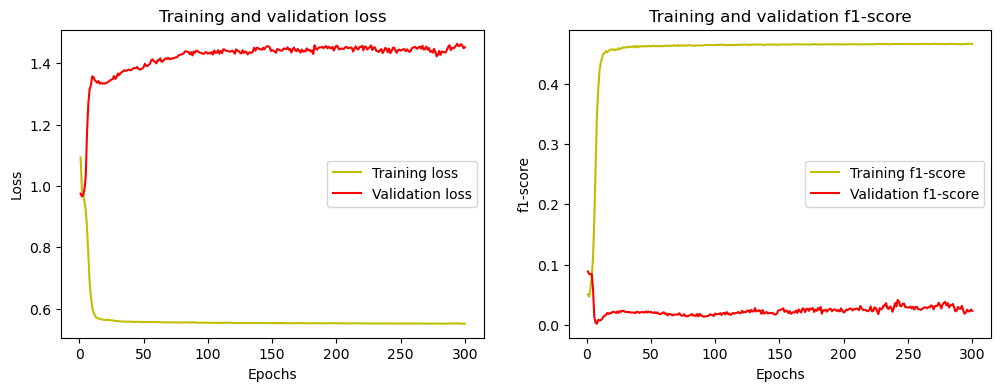

In [21]:
acc_loss_plot(history_seresnet34)

In [22]:
# load the best model
model = tf.keras.models.load_model(fname, compile = False)

# preprocess input
preprocess_input = sm.get_preprocessing(BACKBONE)
X_test1 = preprocess_input(test1_images)
X_test2 = preprocess_input(test2_images)
print(X_test1.shape, X_test2.shape)

y_pred = model.predict([X_test1, X_test2], batch_size=8, verbose=2).squeeze(axis=-1)
# Convert predicted score to binary labels (0 or 1)
y_pred = (y_pred > 0.5).astype(int)

# Flatten arrays
y_true = test_labels.flatten()
y_pred = y_pred.flatten()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1]) # 1st row & column is class 0 & 2nd row & column is class 1

# Calculate metrics for class 1(positive) and class 0(negative)
tp = conf_matrix[1, 1]
fn = conf_matrix[1, 0]
fp = conf_matrix[0, 1]
tn = conf_matrix[0, 0]

# Compute sensitivity (true positive rate) for class 1
sensitivity = tp / (tp + fn)

# Compute specificity (true negative rate) for class 1
specificity = tn / (tn + fp)

# Compute overall accuracy
overall_accuracy = accuracy_score(y_true, y_pred)

# Compute F1 score
f1 = f1_score(y_true, y_pred)

print()
print("Sensitivity (TPR) for class 1:", round(sensitivity, 4))
print("Specificity (TNR) for class 1:", round(specificity, 4))
print("Overall Accuracy:", round(overall_accuracy, 4))
print("F1 Score:", round(f1, 4))

(100, 512, 512, 3) (100, 512, 512, 3)
13/13 - 3s - 3s/epoch - 236ms/step

Sensitivity (TPR) for class 1: 0.0391
Specificity (TNR) for class 1: 0.9772
Overall Accuracy: 0.9123
F1 Score: 0.0582
